<a href="https://colab.research.google.com/github/yohanesnuwara/pyresim/blob/master/simulators/benchmarks/benchmarking_2d_2x2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read the simulation case description [here](https://github.com/yohanesnuwara/pyresim/blob/master/docs/teaser.md#teaser-1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
!git clone https://github.com/yohanesnuwara/pyresim

fatal: destination path 'pyresim' already exists and is not an empty directory.


In [4]:
import sys
sys.path.append('/content/pyresim/functions')

In [5]:
from input_output import read_input
from boundary import boundary2d_location, boundary_flow2d_constant_pressuregrad, boundary_floweq2d
from gridding import fill_active_blocks, source2d
from solver import lhs_coeffs2d_welltype, rhs_constant2d_welltype, fill2d_lhs_mat, fill2d_rhs_mat
from transmissibility import transmissibility2d, transmissibility2d_boundary
from wellblock import prodrate1d, fraction_wellblock_geometric_factor
from wellsimulation import solution_well2d

## Simulator

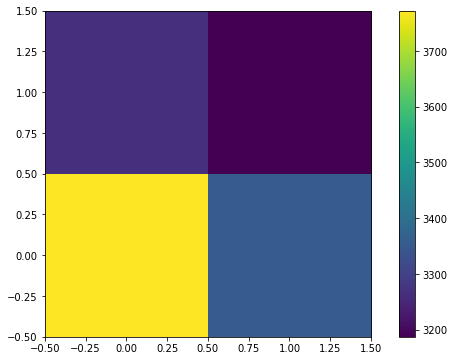

In [22]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/benchmarks/benchmark2d_2x2.txt'

# call the read_input function to read input data
reservoir_input, wells, west_boundary, east_boundary, south_boundary, north_boundary = read_input(filepath)

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']
yi = reservoir_input['yi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
ky = reservoir_input['ky']
B = reservoir_input['B']
mu = reservoir_input['mu']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_condition']
well_value = wells['well_value']
well_config = wells['well_config']

"""""""""""
SPECIFY BOUNDARY CONDITION DISTRIBUTION
"""""""""""

east_boundary = {"type": "constant_pressuregrad", 
        "value": -0.3, 
        "loc": "all"}

west_boundary = {"type": ["constant_rate", "no_flow"], 
        "value": [500, 0], 
        "loc": np.array([[1,1], [1,2]])}

north_boundary = {"type": ["no_flow", "constant_rate"], 
         "value": [0, -200], 
         "loc": [(1,2), (2,2)]}

south_boundary = {"type": "constant_pressure", 
         "value": 4000, 
         "loc": "all"}


"""""""""""
GRIDDING
"""""""""""

" Create grid points "
# meshgrid the original points
x_ = np.arange(1, xi + 1)
y_ = np.arange(1, yi + 1)

x, y = np.meshgrid(x_, y_, indexing='ij')

" Handle irregularities "
# NOTHING. The grid is regular

" Classify the location of boundary with codes (1, 12, 13, etc) "
bound_loc = boundary2d_location(x, y, xi, yi)

"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
qsc = source2d(well_value, np.array(well_loc), xi, yi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, ky, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create WELLBLOCK PROPERTY 
# inject (fill) the operating wells to 'qsc' grid that we created before
# the values won't be filled in the 'qsc' grid that has value = 0
qsc = qsc.astype('float')
qsc[qsc == 0] = np.nan

well_value = qsc
well_condition = fill_active_blocks(well_condition, qsc)
well_rw = fill_active_blocks(well_rw, qsc)
well_Gw = fill_active_blocks(np.array(Gw), qsc)
well_mu = fill_active_blocks(np.array(mu), qsc)
well_B = fill_active_blocks(np.array(B), qsc)

"""""""""""
SIMULATION
"""""""""""

def lookup(i, j, bound_dict):
    """
    Determine the type and value of boundary at a grid block
    given the boundary dictionary
    """
    if bound_dict['loc'] == 'all':
        bound_type = bound_dict['type']
        bound_value = bound_dict['value']
    else:
        x, y = i + 1, j + 1

        id1 = (np.where(np.all(bound_dict['loc'] == np.array([x, y]), axis=-1)))[0][0]
        id2 = (np.where(np.all((bound_dict['loc'][id1]) == np.array([x, y]), axis=-1)))[0][0]

        bound_type = (bound_dict['type'])[id1]
        bound_value = (bound_dict['value'])[id1]
    return bound_type, bound_value

# Create block index
block_index = np.arange(1, (xi * yi) + 1)
block_index = (np.reshape(block_index, (-1, xi))).T

# Create empty matrix for LHS and RHS
lhs_mat = np.array([[0.] * (xi * yi)] * (xi * yi))
rhs_mat = np.array([[0.] * 1] * (xi * yi))

" Start simulation "

for i in range(xi):
    for j in range(yi):

        if bound_loc[i, j] == 13:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 3]),
                        'type': np.array([b1_type, b3_type]),
                        'value': np.array([b1_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 14:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 4]),
                        'type': np.array([b1_type, b4_type]),
                        'value': np.array([b1_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 23:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 3]),
                        'type': np.array([b2_type, b3_type]),
                        'value': np.array([b2_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 24:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 4]),
                        'type': np.array([b2_type, b4_type]),
                        'value': np.array([b2_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 1:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1]),
                        'type': np.array([b1_type]),
                        'value': np.array([b1_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 2:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2]),
                        'type': np.array([b2_type]),
                        'value': np.array([b2_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 3:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([3]),
                        'type': np.array([b3_type]),
                        'value': np.array([b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 4:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([4]),
                        'type': np.array([b4_type]),
                        'value': np.array([b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 0.0:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""
            # create boundary dictionary
            # no boundary
            boundary = {'loc': None,
                        'type': None,
                        'value': None}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}            

        """""""""""
        DO NOT MODIFY THIS
        """""""""""

        # calculate INTER-BLOCK transmissibilities
        T = transmissibility2d(dx, dy, dz, kx, ky, mu, B)
        T = np.array(T)

        # calculate BOUNDARY transmissibilities

        if bound_loc[i, j] == 0.0:
            # Interior blocks. All side are non-boundary, so flow are all inter-block
            T = T
            boundary['T'] = None

        else:
            # Boundary blocks.
            bound_T = []
            for k in range(len(boundary['loc'])):
                a = boundary['loc'][k]
                _ = transmissibility2d_boundary(boundary['loc'][k], boundary['type'][k],
                                                dx, dy, dz, kx, ky, mu, B)
                T[a - 1] = _
                bound_T.append(_)

            boundary['T'] = bound_T

        # calculate LHS coefficients
        px_min, px_plus, py_min, py_plus, p = lhs_coeffs2d_welltype(bound_loc[i, j],
                                                                    well, T, mu, B)

        # calculate potential term 
        # Equals 0. the grid block is not elevated
        potential_term = 0

        # calculate RHS constants
        rhs = rhs_constant2d_welltype('incompressible', boundary, well, 0, dx, dy, 
                                      dz, kx, ky, mu, B)

        # fill in LHS matrix
        lhs_mat = fill2d_lhs_mat(bound_loc[i, j], block_index[i, j], xi, lhs_mat,
                                 px_min, px_plus, py_min, py_plus, p)

        # fill in RHS matrix
        rhs_mat = fill2d_rhs_mat(block_index[i, j], rhs_mat, rhs)

"""""""""""
PRESSURE SOLVER
"""""""""""
p_sol = np.linalg.solve(lhs_mat, rhs_mat)

p_sol = p_sol.T.reshape(-1)

"""""""""""
DISPLAY PRESSURE
"""""""""""

# display well
xsc = np.array(well_loc)[:,0]
ysc = np.array(well_loc)[:,1]

p_sol = p_sol.reshape(-1, xi)
plt.figure(figsize=(10,6))
plt.imshow(p_sol, origin='lower', cmap='viridis')
plt.colorbar()
# plt.scatter(xsc, ysc, color='black')
plt.show()

In [23]:
p_sol

array([[3772.36024824, 3354.1984121 ],
       [3267.38945546, 3187.27109782]])

In [24]:
"""""""""""
WELL SIMULATION
"""""""""""

# create well dataframe
B = np.full(len(well_name), reservoir_input['B'])
mu = np.full(len(well_name), reservoir_input['mu'])
well_df = pd.DataFrame.from_dict(wells)
well_df['well_mu'], well_df['well_B'], well_df['well_Gw'] = mu, B, Gw

# print pressure in order (engineering notations: [0,0], [1,0], [2,0] as 1,2,3)
p_sol = p_sol.T

# FBHP and flow rate solution after pressure in each grid block solved
well_report = solution_well2d(well_df, p_sol)
well_report = well_df.drop(['well_mu', 'well_B', 'well_Gw'], axis=1)
well_report

,well_name,well_loc,well_rw,well_skin,well_condition,well_value,well_config,fbhp_sol,rate_sol
0,A,"[2, 1]",3.0,0.0,constant_fbhp,2000.0,0.0,2000.000000,-1845.134136
1,B,"[1, 2]",3.0,0.0,constant_rate,-600.0,0.0,2827.031743,-600.000000
